# Mini-Project 1
*Kim Concepcion Nielsen*

*Course : Numerical Scientific Computing 2026*

## Hardware Specs
* CPU Model: Quad-Core Intel Core i7
* CPU Cores: 4
* RAM: 16GB
* L2-buffer per core: 256 kB
* L3-buffer: 8 MB

## Operating System Information
* System version: macOS 13.7.8 (22H730)

## Library versions
* Python: 3.11.14

### Python packages (relevant for Mandelbrot / performance)

| Package     | Version |
|------------|--------|
| numpy      | 1.26.4 |
| numba      | 0.63.1 |
| matplotlib | 3.10.8 |
| line_profiler  | 5.0.2  |
| memory_profiler| 0.61.0 |

## Course Intro and Development Tools

### Code

 Median : 10.1225s ( min =10.1122, max =10.2821)


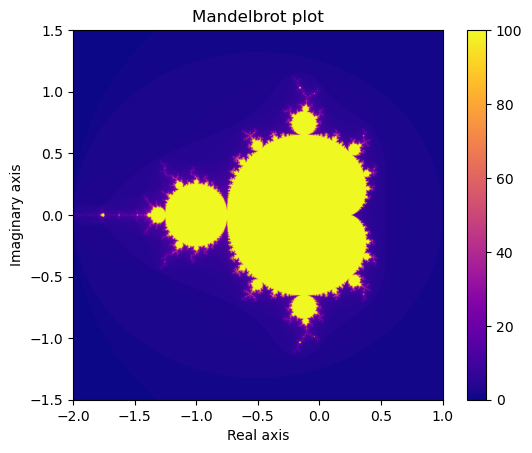

In [1]:
"""
Mandelbrot Set Generator
Author : [ Kim Nielsen ]
Course : Numerical Scientific Computing 2026
"""

# ----------------------------------------------------------------------------------------------------
# Imports
# ----------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import statistics
import math
import time

# ----------------------------------------------------------------------------------------------------
# Parameters
# ----------------------------------------------------------------------------------------------------
width          = 1024
height         = 1024
x_min          = -2.0
x_max          = 1.0
y_min          = -1.5
y_max          = 1.5
max_iteration  = 100 # We set a max iteration as number not part of Mandelbrot set will result in diverging and will keep going forever.
mandelbrot_set = [ [0 for _ in range(width)] for _ in range(height) ] # reset mandelbrot set

# ----------------------------------------------------------------------------------------------------
# Methods
# ----------------------------------------------------------------------------------------------------
def naive_mandelbrot(c, max_iteration) -> int:
    '''
    This function computes Mandelbrot algorithm: z_{n+1} = z_n^2 + c
    The function checks if complex number "c" diverges by iterating over "z_{n+1} = z_n^2 + c"
    At each iteration, the function checks if the magnitude of the new z_{n+1} value exceeds 2, which means that "c" is NOT in the Mandelbrot set and results in divergence.
    The function returns the amount of iterations required before divergence or max iterations if no divergence is detected.
    '''

    # Initialize z value before loop
    z = 0

    for n in range(max_iteration):
        # compute: z_{n+1} = z_n^2 + c
        z = z**2 + c
        # Check if new z value exceeds 2
        if math.sqrt( z.real**2 + z.imag**2 ) > 2:
            return n
    
    # If we reach max_iteration and z has still not diverged, we return max_iteration
    return max_iteration

def create_grid() -> list:
    '''
    Create grid or complex plane of complex numbers that correspond to pixels in output image.
    We create two lists -> one for real part and one for imaginary part.
    '''
    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)
    x  = [ x_min + i*dx for i in range(width)]
    y  = [ 1j * (y_min + i*dy) for i in range(height)]
    C  = [x,y] # Form complex numbers
    return C

def naive_compute_mandelbrot(C_grid:list) -> None:
    '''
    Compute Mandelbrot set by iterating over all pixels and applying mandelbrot function on corresponding complex number.
    '''
    # Loop over all grid complex values and check for divergence with mandelbrot function
    for i in range(height):
        for j in range(width):
            c = C_grid[0][j] + C_grid[1][i] # Form complex number for current pixel
            mandelbrot_set[i][j] = naive_mandelbrot( c, max_iteration )
    return mandelbrot_set

def benchmark ( func , * args , n_runs =3) -> tuple:
    """ Time func , return median of n_runs . """
    times = []
    for _ in range ( n_runs ):
        t0 = time . perf_counter ()
        result = func (* args )
        times . append ( time . perf_counter () - t0 )
    
    median_t = statistics . median ( times )
    
    print (f" Median : { median_t :.4f}s "
        f"( min ={ min( times ):.4f}, max ={ max( times ):.4f})")
    
    return median_t, result

# ----------------------------------------------------------------------------------------------------
# Main region
# ----------------------------------------------------------------------------------------------------
naive_C_grid = create_grid()
t, M = benchmark(naive_compute_mandelbrot, naive_C_grid)

# Plot results
plt.imshow( M, extent=(x_min, x_max, y_min, y_max), cmap='plasma' )
plt.colorbar()
plt.title('Mandelbrot plot')
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.show()

naive_result = M

---

## Computer Architecture and Memory

### Code

Shape: (1024, 1024)
Type: complex128
 Median : 0.8696s ( min =0.8628, max =0.8988)


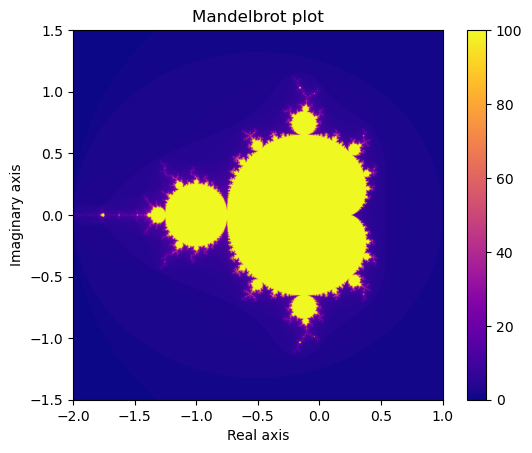

In [2]:
"""
Mandelbrot Set Generator
Author : [ Kim Nielsen ]
Course : Numerical Scientific Computing 2026
"""

# ----------------------------------------------------------------------------------------------------
# Imports
# ----------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import statistics
import time

# ----------------------------------------------------------------------------------------------------
# Parameters
# ----------------------------------------------------------------------------------------------------
width          = 1024
height         = 1024
x_min          = -2.0
x_max          = 1.0
y_min          = -1.5
y_max          = 1.5
max_iteration  = 100 # We set a max iteration as number not part of Mandelbrot set will result in diverging and will keep going forever.
mandelbrot_set = [ [0 for _ in range(width)] for _ in range(height) ] # reset mandelbrot set

# ----------------------------------------------------------------------------------------------------
# Methods
# ----------------------------------------------------------------------------------------------------
def numpy_mandelbrot(Z, C, M, mask):
    '''
    This function computes Mandelbrot algorithm: z_{n+1} = z_n^2 + c
    '''
    # compute: z_{n+1} = z_n^2 + c for all C grid values
    for k in range(max_iteration):
        Z[mask]           = Z[mask]**2 + C[mask]    # We use boolean mask or array to only update points that have not yet diverged -> means all true values in boolean mask
        escaped           = np.abs(Z) > 2           # Check if magnitude of new z point exceeds 2 -> means point diverges. All points that exceed 2, is stored in escaped (also boolean array)
        escaped          &= mask                    # Skip points that diverged earlier
        
        M[escaped] = k                              # We store number of iterations k for points that have diverged the first time.
        mask      &= ~escaped                       # We negate the boolean values in escaped to remove them from the resulting mask, so we only get the non-diverging points which is assumed be in the mandelbrot set.
        
        # Break out of for loop if all booleans in mask are false.
        if not mask.any():
            break
    
    # Points that did not diverge must be in mandelbrot set
    M[mask] = max_iteration
    return M

def numpy_compute_mandelbrot(C_grid):
    '''
    Initialize numpy arrays before Mandelbrot computations. 
    '''
    Z              = np.zeros_like(C_grid)              # Initialize Z as same shape as C grid
    M              = np.zeros(C_grid.shape, dtype=int)  # Initialize M as same shape as C grid
    mask           = np.ones(C_grid.shape, dtype=bool)  # Boolean mask with same shape as C grid, used to check z>2
    return numpy_mandelbrot(Z, C_grid, M, mask)

def create_grid(width, height):
    '''
    Create 1024x1024 grid of complex numbers that correspond to pixels in output image.
    '''
    x    = np.linspace(x_min, x_max, width)  # 1024 horizontal values
    y    = np.linspace(y_min, y_max, height) # 1024 vertical values
    X, Y = np.meshgrid(x,y)                  # 2D grids
    C    = X + 1j * Y                        # Form complex grid

    print(f'Shape: {C.shape}')               # shape=(1024, 1024)
    print(f'Type: {C.dtype}')                # dtype=complex128
    return C

def benchmark ( func , * args , n_runs =3) -> tuple:
    """ Time func , return median of n_runs . """
    times = []
    for _ in range ( n_runs ):
        t0 = time . perf_counter ()
        result = func (* args )
        times . append ( time . perf_counter () - t0 )
    
    median_t = statistics . median ( times )
    
    print (f" Median : { median_t :.4f}s "
        f"( min ={ min( times ):.4f}, max ={ max( times ):.4f})")
    
    return median_t, result

def calc_row_sums(A, N):
    for i in range(N): s = np.sum(A[i, :])

def calc_column_sums(A, N):
    for j in range(N): s = np.sum(A[:, j])

# ----------------------------------------------------------------------------------------------------
# Main region
# ----------------------------------------------------------------------------------------------------
numpy_C_grid = create_grid(width, height)
t, M = benchmark(numpy_compute_mandelbrot, numpy_C_grid)

# Plot Mandelbrot
plt.imshow( M, extent=(x_min, x_max, y_min, y_max), cmap='plasma' )
plt.colorbar()
plt.title('Mandelbrot plot')
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.show()

# Save to compare against naive implementation
numpy_result = M


### Milestones

**Milestone 1: Basic Arrays**

In [3]:
def create_grid(width, height):
    '''
    Create 1024x1024 grid of complex numbers that correspond to pixels in output image.
    '''
    x    = np.linspace(x_min, x_max, width)  # 1024 horizontal values
    y    = np.linspace(y_min, y_max, height) # 1024 vertical values
    X, Y = np.meshgrid(x,y)                  # 2D grids
    C    = X + 1j * Y                        # Form complex grid

    print(f'Shape: {C.shape}')               # shape=(1024, 1024)
    print(f'Type: {C.dtype}')                # dtype=complex128
    return C
C_grid = create_grid(width, height)

Shape: (1024, 1024)
Type: complex128


**Milestone 2: Vectorize Mandelbrot**

Your Task: Replace Python loops with NumPy operations

In [4]:
def numpy_mandelbrot(Z, C, M, mask):
    '''
    This function computes Mandelbrot algorithm: z_{n+1} = z_n^2 + c
    '''
    # compute: z_{n+1} = z_n^2 + c for all C grid values
    for k in range(max_iteration):
        Z[mask]           = Z[mask]**2 + C[mask]    # We use boolean mask or array to only update points that have not yet diverged -> means all true values in boolean mask
        escaped           = np.abs(Z) > 2           # Check if magnitude of new z point exceeds 2 -> means point diverges. All points that exceed 2, is stored in escaped (also boolean array)
        M[escaped & mask] = k                       # By ANDing values in escaped and current values in mask, we store number of iterations for points that have diverged the first time.
        mask             &= ~escaped                # We negate the boolean values in escaped to remove them from the resulting mask, so we only get the non-diverging points which is assumed be in the mandelbrot set.
    return M

def numpy_compute_mandelbrot(C_grid):
    '''
    Initialize numpy arrays before Mandelbrot computations. 
    '''
    Z              = np.zeros_like(C_grid)              # Initialize Z as same shape as C grid
    M              = np.zeros(C_grid.shape, dtype=int)  # Initialize M as same shape as C grid
    mask           = np.ones(C_grid.shape, dtype=bool)  # Boolean mask with same shape as C grid, used to check z>2
    return numpy_mandelbrot(Z, C_grid, M, mask)

In [5]:
print( type(naive_result) )
print( type(numpy_result) )


# CORRECT - Use np. allclose ():
if np.allclose(naive_result, numpy_result ):
    print (" Results match !")
else:
    print (" Results differ !")

# Check where they differ :
diff = np .abs ( naive_result - numpy_result )
print (f" Max difference : { diff . max ()}")
print (f" Different pixels : {( diff > 0). sum ()}")

<class 'list'>
<class 'numpy.ndarray'>
 Results match !
 Max difference : 0
 Different pixels : 0


**Milestone 3: Memory Access Patterns**

In [6]:
N = 10000
A = np.random.rand(N, N)
A_f = np.asfortranarray(A)

# Python -> moves fastest row wise
t, M = benchmark(calc_row_sums, A, N)
t, M = benchmark(calc_column_sums, A, N)

# Fortran -> moves fastest column wise
t, M = benchmark(calc_row_sums, A_f, N)
t, M = benchmark(calc_column_sums, A_f, N)

 Median : 0.1158s ( min =0.1148, max =0.1175)
 Median : 1.2582s ( min =1.2302, max =1.2600)
 Median : 0.9759s ( min =0.9609, max =1.0546)
 Median : 0.0942s ( min =0.0916, max =0.0967)


Based on the results, it appears that Fortran is faster, when performing column wise summation, while Python/C is faster at row wise summation.

**Milestone 4: Problem Size Scaling**

Shape: (256, 256)
Type: complex128
 Median : 0.0360s ( min =0.0344, max =0.0456)
Shape: (512, 512)
Type: complex128
 Median : 0.1441s ( min =0.1423, max =0.1690)
Shape: (1024, 1024)
Type: complex128
 Median : 0.8149s ( min =0.8110, max =0.9152)
Shape: (2048, 2048)
Type: complex128
 Median : 3.9783s ( min =3.8472, max =4.1603)
Shape: (4096, 4096)
Type: complex128
 Median : 16.6079s ( min =16.6040, max =17.6417)


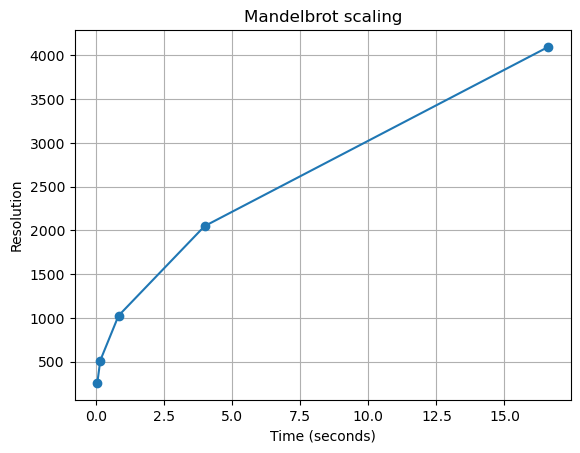

In [7]:
# Timeline plot
sizes = [256, 512, 1024, 2048, 4096]
times = []

for s in sizes:
    C_grid = create_grid(s, s)
    t, _ = benchmark(numpy_compute_mandelbrot, C_grid)
    times.append(t)

plt.plot(times, sizes, marker='o')
plt.ylabel('Resolution')
plt.xlabel('Time (seconds)')
plt.title('Mandelbrot scaling')
plt.grid()
plt.show()

Problem Size Scaling. Executions for 256, 512 and 1024 can be kept under 2 seconds, but afterwards the performance drops. 4096x4096 on average took almost 17 seconds

---

## Optimization and Numba

### Code

In [11]:
"""
Mandelbrot Set Generator
Author : [ Kim Nielsen ]
Course : Numerical Scientific Computing 2026
"""

# ----------------------------------------------------------------------------------------------------
# Imports
# ----------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import statistics
import time

import numpy as np
from numba import jit, njit, prange

# ----------------------------------------------------------------------------------------------------
# Parameters
# ----------------------------------------------------------------------------------------------------
width          = 1024
height         = 1024
x_min          = -2.0
x_max          = 1.0
y_min          = -1.5
y_max          = 1.5
max_iteration  = 100 # We set a max iteration as number not part of Mandelbrot set will result in diverging and will keep going forever.

# ----------------------------------------------------------------------------------------------------
# Methods
# ----------------------------------------------------------------------------------------------------
def create_grid(width, height, dtype=np.float64):
    x = np.linspace(x_min, x_max, width).astype(dtype)
    y = np.linspace(y_min, y_max, height).astype(dtype)
    X, Y = np.meshgrid(x,y)
    C = X + 1j * Y # Form complex numbers

    print(f'dtype: {dtype}, dtype: c[0,0] dtype: { type( C[0, 0] )}')
    return C

@njit
def mandelbrot_point_numba(c, max_iteration=100) -> None:
    z = c * 0
    for n in range(max_iteration):
        z = z*z + c
        if ( z.real*z.real + z.imag*z.imag ) > 4:
            return n
    return max_iteration

def mandelbrot_hybrid(C_grid) -> None:
    '''
    Compute Mandelbrot set by iterating over all pixels and applying mandelbrot function on corresponding complex number.
    '''
    mandelbrot_set = np.zeros(C_grid.shape, dtype=np.int32)

    # Loop over all grid complex values and check for divergence with mandelbrot function
    height, width = C_grid.shape
    for i in range(height):
        for j in range(width):
            c = C_grid[i, j]
            mandelbrot_set[i,j] = mandelbrot_point_numba(c, max_iteration=max_iteration)
    return mandelbrot_set

@njit(parallel=True, fastmath=True)
def mandelbrot_naive_numba(C_grid) -> None:
    '''
    Compute Mandelbrot set by iterating over all pixels and applying mandelbrot function on corresponding complex number.
    '''
    mandelbrot_set = np.zeros(C_grid.shape, dtype=np.int32)

    # Loop over all grid complex values and check for divergence with mandelbrot function
    height, width = C_grid.shape
    for i in range(height):
        for j in range(width):
            c = C_grid[i, j]
            
            # Initialize z value before loop
            z = 0

            converged = True # Just used to check if we break out of loop
            for n in range(max_iteration):
                # compute: z_{n+1} = z_n^2 + c
                z = z*z + c

                # Check if new z value exceeds 2
                if ( z.real*z.real + z.imag*z.imag ) > 4: # We don't really need to do the sqrt here, as we know sqrt of the result is 2 anyway...
                    mandelbrot_set[i,j] = n
                    converged = False
                    break
            
            if converged:
                mandelbrot_set[i,j] = max_iteration
    
    return mandelbrot_set

def benchmark ( func , * args , n_runs =3) -> tuple:
    """ Time func , return median of n_runs . """
    times = []
    for _ in range ( n_runs ):
        t0 = time . perf_counter ()
        result = func (* args )
        times . append ( time . perf_counter () - t0 )
    
    median_t = statistics . median ( times )
    
    print (f" Median : { median_t :.4f}s "
        f"( min ={ min( times ):.4f}, max ={ max( times ):.4f})")
    
    return median_t, result

### Milestones

**Milestone 1: Function-Level Profiling**

In [8]:
import cProfile , pstats

cProfile.run ('naive_compute_mandelbrot (naive_C_grid)', 'naive_profile.prof')
cProfile.run ('numpy_compute_mandelbrot (numpy_C_grid)', 'numpy_profile.prof')

for name in ('naive_profile.prof', 'numpy_profile.prof'):
    stats = pstats.Stats (name)
    stats.sort_stats('cumulative')
    stats.print_stats(10)


Sat Feb 28 18:51:42 2026    naive_profile.prof

         23008314 function calls in 15.838 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   15.838   15.838 {built-in method builtins.exec}
        1    0.000    0.000   15.838   15.838 <string>:1(<module>)
        1    0.634    0.634   15.838   15.838 /var/folders/v2/99ntmfk90bb_y5jznq4rq7f40000gn/T/ipykernel_18136/1214517057.py:63(naive_compute_mandelbrot)
  1048576   12.988    0.000   15.203    0.000 /var/folders/v2/99ntmfk90bb_y5jznq4rq7f40000gn/T/ipykernel_18136/1214517057.py:30(naive_mandelbrot)
 21959734    2.215    0.000    2.215    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


Sat Feb 28 18:51:43 2026    numpy_profile.prof

         14 function calls in 1.040 seconds

   Ordered by: cumulative time
   List reduced from 12 to 10 due to restriction <10>

 

*Questions to answer:*

1. Which function takes most total time? *Based on the profiler results, it seems it is the naive_mandelbrot function that takes the most time in the naive implementation.*

2. Are there functions called surprisingly many times? *Both naive_mandelbrot and sqrt functions are called very often in the naive implementation.*

3. How does NumPy profile compare to naive? *NumPy is way faster than the naive implementation. The number of calls is much lower in the NumPy implementation.*

4. Where does NumPy spend its time?
*The NumPy implementation spends most of its time in the numpy_mandelbrot function. Yet, the cumtime lies only at 1.027s. NumPy itself also spends time in functions like numpy.zeros and numpy.empty, but this is a very tiny amount of time. The cumtime for numpy.zeros is 0.003 according to the profiler results.*


**Summary Table (Naive)**
| ncalls   | tottime | cumtime | function |
| -------- | ------- | ------- | -------|
| 1  | 0.634 | 15.838 | naive_compute_mandelbrot
| 1048576  | 12.988 | 15.203 | naive_mandelbrot
| 21959734  | 2.215 | 2.215 | math.sqrt

**Summary Table (Numpy)**
| ncalls   | tottime | cumtime | function |
| -------- | ------- | ------- | -------|
| 1  | 0.003 | 1.036 | numpy_compute_mandelbrot
| 1  | 1.027 | 1.027 | numpy_mandelbrot


**Milestone 2: Line-Level Profiling**

*Naive Line Profiler output*
```
# Median : 50.8358s ( min =50.7360, max =51.1930)
# Wrote profile results to 'naive_python_mandelbrot.py.lprof'
# Timer unit: 1e-06 s

# Total time: 107.585 s
# File: naive_python_mandelbrot.py
# Function: mandelbrot at line 34

# Line #      Hits         Time  Per Hit   % Time  Line Contents
# ==============================================================
#     34                                           @profile
#     35                                           def mandelbrot(c, max_iteration) -> int:
#     36                                               '''
#     37                                               This function computes Mandelbrot algorithm: z_{n+1} = z_n^2 + c
#     38                                               The function checks if complex number "c" diverges by iterating over "z_{n+1} = z_n^2 + c"
#     39                                               At each iteration, the function checks if the magnitude of the new z_{n+1} value exceeds 2, which means that "c" is NOT in the Mandelbrot set and results in divergence.
#     40                                               The function returns the amount of iterations required before divergence or max iterations if no divergence is detected.
#     41                                               '''
#     42                                           
#     43                                               # Initialize z value before loop
#     44   3145728     950437.0      0.3      0.9      z = 0
#     45                                           
#     46  66418440   18902047.0      0.3     17.6      for n in range(max_iteration):
#     47                                                   # compute: z_{n+1} = z_n^2 + c
#     48  65879202   27549502.0      0.4     25.6          z = z**2 + c
#     49                                                   # Check if new z value exceeds 2
#     50  65879202   59189397.0      0.9     55.0          if math.sqrt( z.real**2 + z.imag**2 ) > 2:
#     51   2606490     824953.0      0.3      0.8              return n
#     52                                               
#     53                                               # If we reach max_iteration and z has still not diverged, we return max_iteration
#     54    539238     168253.0      0.3      0.2      return max_iteration
```
The "math.sqrt( z.real**2 + z.imag**2 ) > 2" check takes 55% of the time spent in the function. This is the bottleneck of the function.


*Numpy Line Profiler output*
```
    # Shape: (1024, 1024)
    # Type: complex128
    # Median : 0.8386s ( min =0.8300, max =0.8686)
    # Wrote profile results to 'numpy_mandelbrot.py.lprof'
    # Timer unit: 1e-06 s

    # Total time: 2.51328 s
    # File: numpy_mandelbrot.py
    # Function: mandelbrot at line 34

    # Line #      Hits         Time  Per Hit   % Time  Line Contents
    # ==============================================================
    #     34                                           @profile
    #     35                                           def mandelbrot(Z, C, M, mask):
    #     36                                               '''
    #     37                                               This function computes Mandelbrot algorithm: z_{n+1} = z_n^2 + c
    #     38                                               '''
    #     39                                               # compute: z_{n+1} = z_n^2 + c for all C grid values
    #     40       303        199.0      0.7      0.0      for k in range(max_iteration):
    #     41       300    1235212.0   4117.4     49.1          Z[mask]           = Z[mask]**2 + C[mask]    # We use boolean mask or array to only update points that have not yet diverged -> means all true values in boolean mask
    #     42       300    1085488.0   3618.3     43.2          escaped           = np.abs(Z) > 2           # Check if magnitude of new z point exceeds 2 -> means point diverges. All points that exceed 2, is stored in escaped (also boolean array)
    #     43       300     143335.0    477.8      5.7          M[escaped & mask] = k                       # By ANDing values in escaped and current values in mask, we store number of iterations for points that have diverged the first time.
    #     44       300      49043.0    163.5      2.0          mask             &= ~escaped                # We negate the boolean values in escaped to remove them from the resulting mask, so we only get the non-diverging points which is assumed be in the mandelbrot set.
    #     45         3          3.0      1.0      0.0      return M
```

The "Z[mask] = Z[mask]**2 + C[mask]" and "escaped = np.abs(Z) > 2" occupies most of the time spent in the function. These are the bottlenecks of the function.

**Milestone 2: Add Profiling Section to Mini-Report**

Add a profiling section to your MP1 mini-report. In your own words, answer:

* cProfile on naive vs NumPy: How many functions appear in each profile? What does this difference tell you about where the work actually happens?
*The cProfile reported 6 functions for the naive implementation and 7 for the numpy implementation. Although, numpy has an additional reported function, it has far fewer number of calls than the naive implementation.*

* line profiler on naive: Which lines dominate runtime? What fraction of total time is spent in the inner loop?
*The "math.sqrt( z.real**2 + z.imag**2 ) > 2" check takes 55% of the time spent in the function. This is clearly the bottleneck of the function.*

* Based on your profiling results: why is NumPy faster than naive Python?
*Based on the cProfile results, Numpy in most cases only has a single function call. For instance the number of calls for numpy_mandelbrot is 1 and the duration of this single call is far less than the cumulative time for e.g. naive_mandelbrot function*

* What would you need to change to make the naive version faster? (hint: what does line profiler tell you about the inner loop?)
*The line profiler indicated that the sqrt check occupies about 55% of the time spent in the naive_mandelbrot function. This is clearly the bottleneck and could be optimized. The fix is fairly simple. We could simply remove the sqrt() call and just check if the same expression is greater than 4*

**Milestone 3: Implement & Compare Approaches**

Expected: fully compiled is usually faster — outer-loop dispatch to JIT adds up over 1M pixels.

In [12]:
# Milestone 3: Implement & Compare Approaches
C_grid = create_grid(1024, 1024)

t_hybrid, M = benchmark(mandelbrot_hybrid, C_grid, n_runs=1)      # Includes benchmark time to compile functions
t_hybrid, M = benchmark(mandelbrot_hybrid, C_grid, n_runs=1)      # Excludes benchmark time to compile functions
t_full, M   = benchmark(mandelbrot_naive_numba, C_grid, n_runs=1) # Includes benchmark time to compile functions
t_full, M   = benchmark(mandelbrot_naive_numba, C_grid, n_runs=1) # Excludes benchmark time to compile functions

# Milestone 3: Implement & Compare Approaches
print (f" Hybrid : { t_hybrid :.3f}s")
print (f" Fully compiled : { t_full :.3f}s")
print (f" Ratio : { t_hybrid / t_full :.1f}x")

dtype: <class 'numpy.float64'>, dtype: c[0,0] dtype: <class 'numpy.complex128'>
 Median : 1.6754s ( min =1.6754, max =1.6754)
 Median : 0.8973s ( min =0.8973, max =0.8973)
 Median : 0.7953s ( min =0.7953, max =0.7953)
 Median : 0.0764s ( min =0.0764, max =0.0764)
 Hybrid : 0.897s
 Fully compiled : 0.076s
 Ratio : 11.7x


**Milestone 3: Benchmark All Versions**

Add timings and speedup table (naive / NumPy / Numba) to your mini-report 

In [14]:
t_naive, _ = benchmark ( naive_compute_mandelbrot, naive_C_grid, n_runs=3)
t_numpy, _ = benchmark ( numpy_compute_mandelbrot, numpy_C_grid, n_runs=3)
t_numba, _ = benchmark ( mandelbrot_naive_numba, C_grid, n_runs=3)

print (f" Naive : { t_naive :.3f}s")
print (f" NumPy : { t_numpy :.3f}s ({ t_naive / t_numpy :.1f}x)")
print (f" Numba : { t_numba :.3f}s ({ t_naive / t_numba :.1f}x)")

 Median : 10.2604s ( min =10.1569, max =10.3099)
 Median : 0.8704s ( min =0.8700, max =0.8732)
 Median : 0.0749s ( min =0.0743, max =0.0759)
 Naive : 10.260s
 NumPy : 0.870s (11.8x)
 Numba : 0.075s (136.9x)


**Benchmark Table (based on above results)**
| Version   | Time | Speedup |
| -------- | ------- | ------- |
| Numpy  | 10.260s | 0 |
| Numpy  | 0.870s | 11.8x |
| Numba  | 0.075s | 136.9x |

**Milestone 4: Visual Comparison**

Compare accuracy and generate side-by-side images:

dtype: <class 'numpy.float16'>, dtype: c[0,0] dtype: <class 'numpy.complex64'>
 Median : 0.9567s ( min =0.9199, max =1.1590)
dtype: <class 'numpy.float32'>, dtype: c[0,0] dtype: <class 'numpy.complex64'>
 Median : 0.9171s ( min =0.9069, max =1.0434)
dtype: <class 'numpy.float64'>, dtype: c[0,0] dtype: <class 'numpy.complex128'>
 Median : 0.9067s ( min =0.8748, max =1.0595)
 Max diff float32 vs float64 : 34
 Max diff float16 vs float64 : 80


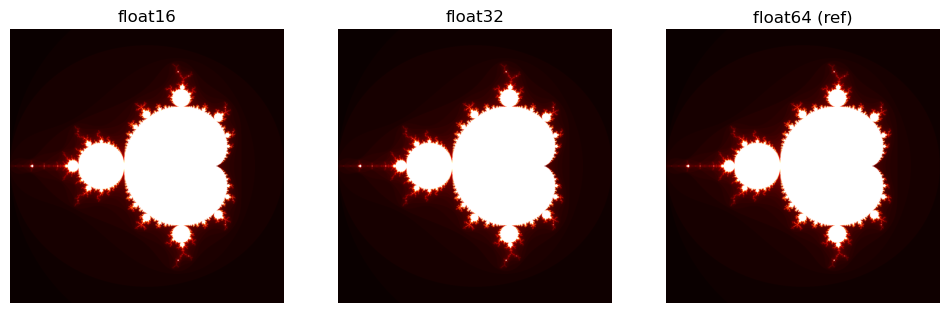

In [15]:
_, r16 = benchmark ( mandelbrot_hybrid, create_grid(1024, 1024, dtype=np.float16), n_runs=10)
_, r32 = benchmark ( mandelbrot_hybrid, create_grid(1024, 1024, dtype=np.float32), n_runs=10)
_, r64 = benchmark ( mandelbrot_hybrid, create_grid(1024, 1024, dtype=np.float64), n_runs=10)

fig, axes = plt.subplots(1 , 3, figsize=(12 , 4))
for ax, result, title in zip ( axes, [r16 , r32 , r64], ['float16', 'float32', 'float64 (ref)']):
    ax.imshow(result, cmap ='hot')
    ax.set_title(title); ax.axis ('off')

plt.savefig('precision_comparison.pdf', dpi=600)
print (f" Max diff float32 vs float64 : {np.abs(r32 - r64).max()}")
print (f" Max diff float16 vs float64 : {np.abs(r16 - r64).max()}")

**Milestone 4: What to Look For**

Run your experiments and observe:

* Speed: Does float32 actually run faster than float64 on your hardware? By how much?
Is float16 faster or slower — and why might that surprise you?
*Based on my results, it does not seem that float32 actually run faster than float64. However, the results indicate that float16 results in the slowest run of all 3 datatypes. Some CPUs might not support float16 for mathematical operations, so it might get converted to float32 behind the scenes during calculation and then converted back to float16. This adds additional overhead*


* Visual quality: Zoom in on a detailed region of the Mandelbrot set. Can you see
artefacts with float16? What about float32?
*The overall structure appears quite similar. I would have expected the float16 image to indicate small inaccuracies, yet it does not seem to be present.*

* Recommendation: Based on what you observe, which precision would you choose for
production use, and why?
*Based on the observed results and considering the trade-off between performance and precision, float32 would be a good choice. It is more precise than float16 and uses less memory than float64.*